# MODEL TRAINING NOTEBOOK - CHALLENGE - PART 1 - MULTICLASS CLASSIFICATION

**Author:** Sushmetha S R – VIT Chennai  
**Team Name:** *expendables*  
**Team Members:** Abhinav Chaitanya R, Arjun M, Harshavardhan S, Kiranchandran H, Sushmetha S R  
**Leaderboard Rank:** 69  


# This is the notebook used for training the model.

# Importing Libraries

In [27]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from sklearn.metrics import f1_score
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Dataset Loading and Analysis

In [28]:
# Define paths
base_dir = "/kaggle/input/soil-classification/soil_classification-2025"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
train_labels_path = os.path.join(base_dir, "train_labels.csv")
test_ids_path = os.path.join(base_dir, "test_ids.csv")

# Load CSV files
train_df = pd.read_csv(train_labels_path)
test_df = pd.read_csv(test_ids_path)

# Dataset Overview
print("=== Dataset Overview ===")
print(f"Train DataFrame Shape: {train_df.shape}")
print(f"Test DataFrame Shape: {test_df.shape}")
print("\nTrain DataFrame Info:")
print(train_df.info())
print("\nTest DataFrame Info:")
print(test_df.info())

print("\n=== Missing Values ===")
print("Train DataFrame Missing Values:")
print(train_df.isnull().sum())
print("\nTest DataFrame Missing Values:")
print(test_df.isnull().sum())

print("\n=== Unique Values ===")
print("\nTrain Unique Values:")
for column in train_df.columns:
    unique_values = train_df[column].nunique()
    print(f"  Values: {train_df[column].unique()}")

# Image File Analysis
print("\n=== Image File Analysis ===")
def count_image_files(directory):
    image_extensions = ('.jpg', '.jpeg', '.png', '.webp')
    return {ext: len([f for f in os.listdir(directory) if f.lower().endswith(ext)]) for ext in image_extensions}

print(f"Train Directory Image Counts: {count_image_files(train_dir)}")
print(f"Test Directory Image Counts: {count_image_files(test_dir)}")

# Class Distribution (Train Only)
if 'soil_type' in train_df.columns:
    print("\n=== Class Distribution ===")
    print(train_df['soil_type'].value_counts())

=== Dataset Overview ===
Train DataFrame Shape: (1222, 2)
Test DataFrame Shape: (341, 1)

Train DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222 entries, 0 to 1221
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image_id   1222 non-null   object
 1   soil_type  1222 non-null   object
dtypes: object(2)
memory usage: 19.2+ KB
None

Test DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  341 non-null    object
dtypes: object(1)
memory usage: 2.8+ KB
None

=== Missing Values ===
Train DataFrame Missing Values:
image_id     0
soil_type    0
dtype: int64

Test DataFrame Missing Values:
image_id    0
dtype: int64

=== Unique Values ===

Train Unique Values:
  Values: ['img_ed005410.jpg' 'img_0c5ecd2a.jpg' 'img_ed713bb5.jpg' ...
 'img_5c4372f8.jpg' 

# Path Setup and CSV Loading

In [29]:
train_dir = "/kaggle/input/soil-classification/soil_classification-2025/train"
test_dir = "/kaggle/input/soil-classification/soil_classification-2025/test"
train_labels_path = "/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv"
test_ids_path = "/kaggle/input/soil-classification/soil_classification-2025/test_ids.csv"
submission_path = "Submission.csv"

train_df = pd.read_csv(train_labels_path)
test_df = pd.read_csv(test_ids_path)

# Class Distribution

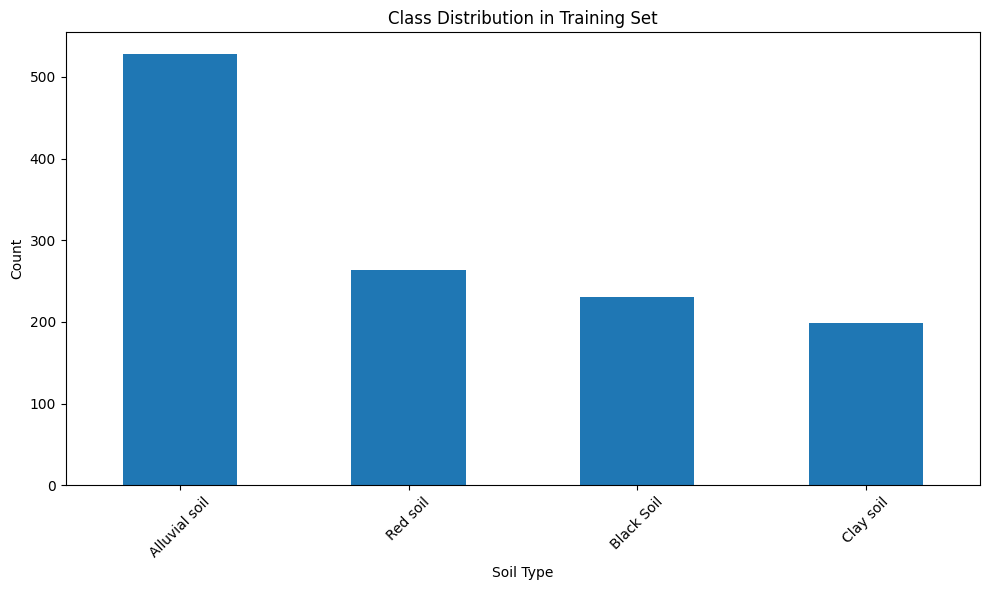

In [30]:
def plot_class_distribution(df, label_col, title):
    counts = df[label_col].value_counts()
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel("Soil Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_df, 'soil_type', "Class Distribution in Training Set")


# Sample Training Data

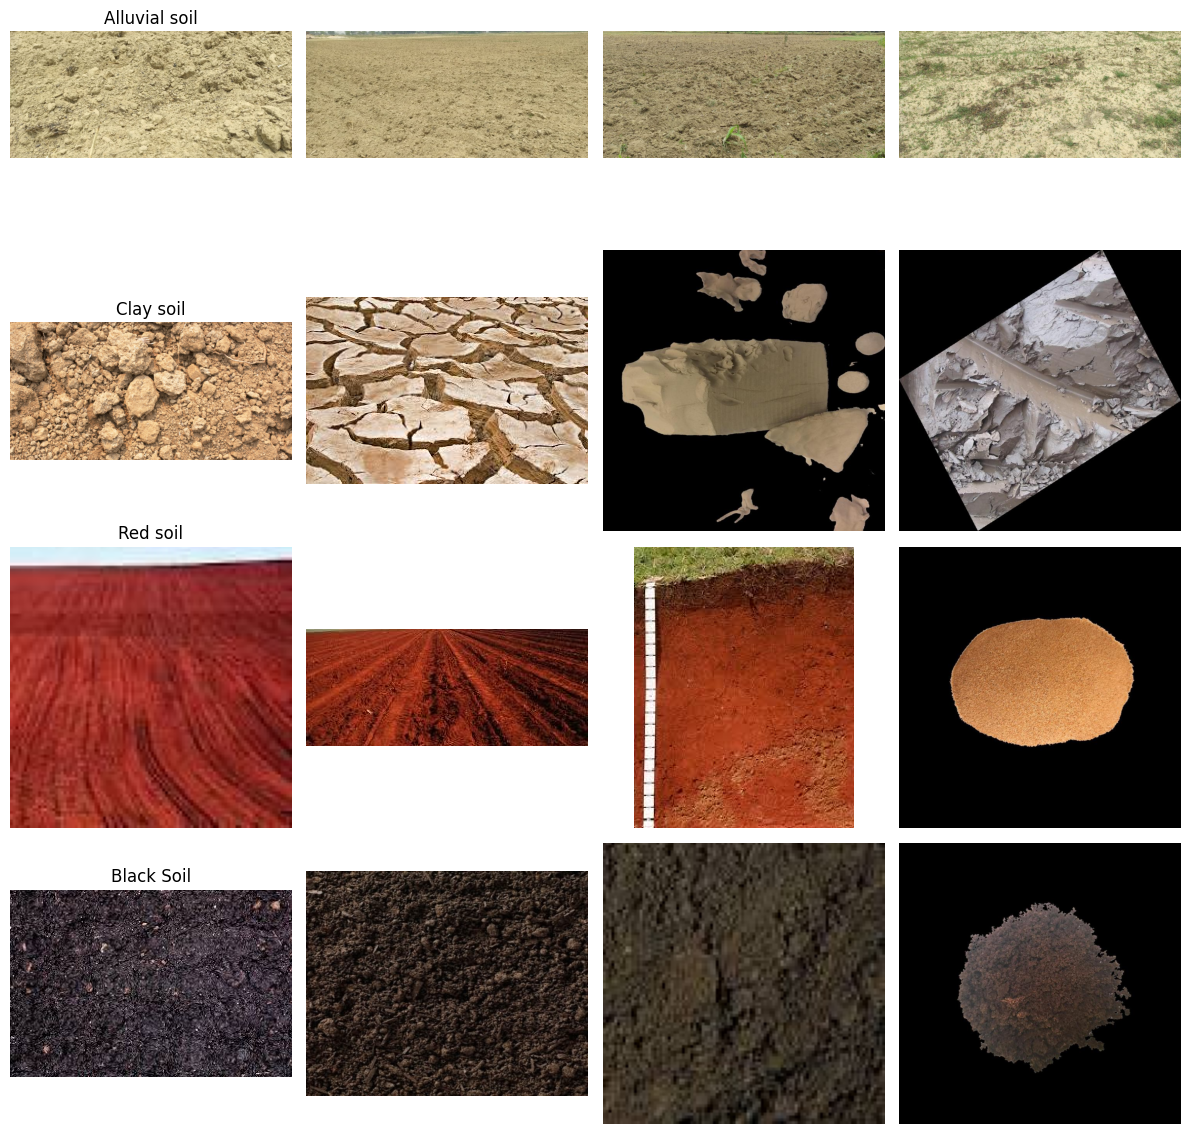

In [31]:
def show_sample_images(df, root_dir, label_col, num_per_class=3):
    classes = df[label_col].unique()
    fig, axes = plt.subplots(len(classes), num_per_class, figsize=(num_per_class*3, len(classes)*3))

    for i, cls in enumerate(classes):
        sample_imgs = df[df[label_col] == cls].sample(num_per_class, random_state=42)
        for j, img_id in enumerate(sample_imgs['image_id'].values):
            img_path = os.path.join(root_dir, img_id)
            image = Image.open(img_path).convert('RGB')
            ax = axes[i, j] if len(classes) > 1 else axes[j]
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(cls if j == 0 else "")
    
    plt.tight_layout()
    plt.show()

show_sample_images(train_df, train_dir, 'soil_type', num_per_class=4)


# Loading Training Data

In [32]:
label_encoder = LabelEncoder()
train_df['soil_type_encoded'] = label_encoder.fit_transform(train_df['soil_type'])
num_classes = len(label_encoder.classes_)
print(f"Label encoding: {dict(zip(label_encoder.classes_, range(num_classes)))}")

train_split, val_split = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['soil_type'],
    random_state=42
)
print("Training data: ",len(train_split))
print("Validation data: ",len(val_split))

class_counts = train_split['soil_type'].value_counts()
total_samples = len(train_split)
class_weights = torch.FloatTensor([total_samples / (num_classes * count) for count in class_counts.sort_index().values])

Label encoding: {'Alluvial soil': 0, 'Black Soil': 1, 'Clay soil': 2, 'Red soil': 3}
Training data:  977
Validation data:  245


# Data Transformations

In [33]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset Loader Class

In [34]:
class SoilDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, is_test=False):
        self.data_frame = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test
        self.data_frame['path'] = self.data_frame['image_id'].apply(lambda x: os.path.join(root_dir, x))

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_path = self.data_frame.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        if self.is_test:
            return image, -1 
        label = self.data_frame.iloc[idx]['soil_type_encoded']
        return image, label

In [35]:
train_dataset = SoilDataset(train_split, train_dir, transform=train_transforms)
val_dataset = SoilDataset(val_split, train_dir, transform=val_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Model Definition

In [46]:
model = models.efficientnet_v2_s(weights='EfficientNet_V2_S_Weights.DEFAULT')

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model.classifier[1].in_features, num_classes)
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("Model has been loaded with pretrained weights")

Model has been loaded with pretrained weights


# Loss Function & Optimizer Setup

In [47]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  
        self.reduction = reduction

    def forward(self, inputs, targets, weights=None):
        alpha = self.alpha.to(targets.device) if self.alpha is not None else None
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if alpha is not None:
            alpha = alpha[targets]
            focal_loss = alpha * focal_loss
        if weights is not None:
            focal_loss = focal_loss * weights.to(targets.device)
        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        return focal_loss

criterion = FocalLoss(gamma=2.0, alpha=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Model Training

In [48]:
best_val_f1 = 0.0
model_save_path = 'best_model_comp1.pth'
num_epochs = 30
train_losses = []
val_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit='batch'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * images.size(0)

    scheduler.step()
    avg_loss = epoch_loss / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

    # ---------- Validation ----------
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            outputs = model(val_images)

            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())

    val_f1 = f1_score(all_labels, all_preds, average='macro')  # or 'weighted'
    print(f"Validation F1 Score: {val_f1:.4f}")
    train_losses.append(avg_loss)
    val_f1_scores.append(val_f1)
    # Save the model if F1 improves
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), model_save_path)
        print("✅ Model saved (new best F1)")


Epoch 1/30: 100%|██████████| 31/31 [00:12<00:00,  2.54batch/s]

Epoch 1/30, Training Loss: 0.4644


Validation F1 Score: 0.8506
✅ Model saved (new best F1)


Epoch 2/30: 100%|██████████| 31/31 [00:12<00:00,  2.43batch/s]

Epoch 2/30, Training Loss: 0.1193


Validation F1 Score: 0.9581
✅ Model saved (new best F1)


Epoch 3/30: 100%|██████████| 31/31 [00:13<00:00,  2.38batch/s]

Epoch 3/30, Training Loss: 0.0476


Validation F1 Score: 0.9738
✅ Model saved (new best F1)


Epoch 4/30: 100%|██████████| 31/31 [00:13<00:00,  2.36batch/s]

Epoch 4/30, Training Loss: 0.0261


Validation F1 Score: 0.9760
✅ Model saved (new best F1)


Epoch 5/30: 100%|██████████| 31/31 [00:12<00:00,  2.43batch/s]

Epoch 5/30, Training Loss: 0.0233


Validation F1 Score: 0.9830
✅ Model saved (new best F1)


Epoch 6/30: 100%|██████████| 31/31 [00:12<00:00,  2.51batch/s]

Epoch 6/30, Training Loss: 0.0134


Validation F1 Score: 0.9726


Epoch 7/30: 100%|██████████| 31/31 [00:12<00:00,  2.49batch/s]

Epoch 7/30, Training Loss: 0.0236


Validation F1 Score: 0.9696


Epoch 8/30: 100%|██████████| 31/31 [00:12<00:00,  2.48batch/s]

Epoch 8/30, Training Loss: 0.0114


Validation F1 Score: 0.9745


Epoch 9/30: 100%|██████████| 31/31 [00:12<00:00,  2.43batch/s]

Epoch 9/30, Training Loss: 0.0110


Validation F1 Score: 0.9745


Epoch 10/30: 100%|██████████| 31/31 [00:12<00:00,  2.42batch/s]

Epoch 10/30, Training Loss: 0.0128


Validation F1 Score: 0.9696


Epoch 11/30: 100%|██████████| 31/31 [00:12<00:00,  2.44batch/s]

Epoch 11/30, Training Loss: 0.0088


Validation F1 Score: 0.9745


Epoch 12/30: 100%|██████████| 31/31 [00:12<00:00,  2.45batch/s]

Epoch 12/30, Training Loss: 0.0101


Validation F1 Score: 0.9696


Epoch 13/30: 100%|██████████| 31/31 [00:12<00:00,  2.45batch/s]

Epoch 13/30, Training Loss: 0.0061


Validation F1 Score: 0.9696


Epoch 14/30: 100%|██████████| 31/31 [00:12<00:00,  2.46batch/s]

Epoch 14/30, Training Loss: 0.0058


Validation F1 Score: 0.9745


Epoch 15/30: 100%|██████████| 31/31 [00:12<00:00,  2.45batch/s]

Epoch 15/30, Training Loss: 0.0055


Validation F1 Score: 0.9696


Epoch 16/30: 100%|██████████| 31/31 [00:12<00:00,  2.44batch/s]

Epoch 16/30, Training Loss: 0.0084


Validation F1 Score: 0.9745


Epoch 17/30: 100%|██████████| 31/31 [00:12<00:00,  2.44batch/s]

Epoch 17/30, Training Loss: 0.0056


Validation F1 Score: 0.9745


Epoch 18/30: 100%|██████████| 31/31 [00:12<00:00,  2.47batch/s]

Epoch 18/30, Training Loss: 0.0092


Validation F1 Score: 0.9696


Epoch 19/30: 100%|██████████| 31/31 [00:12<00:00,  2.48batch/s]

Epoch 19/30, Training Loss: 0.0051


Validation F1 Score: 0.9696


Epoch 20/30: 100%|██████████| 31/31 [00:12<00:00,  2.45batch/s]

Epoch 20/30, Training Loss: 0.0065


Validation F1 Score: 0.9696


Epoch 21/30: 100%|██████████| 31/31 [00:12<00:00,  2.40batch/s]

Epoch 21/30, Training Loss: 0.0059


Validation F1 Score: 0.9745


Epoch 22/30: 100%|██████████| 31/31 [00:12<00:00,  2.45batch/s]

Epoch 22/30, Training Loss: 0.0112


Validation F1 Score: 0.9696


Epoch 23/30: 100%|██████████| 31/31 [00:12<00:00,  2.45batch/s]

Epoch 23/30, Training Loss: 0.0064


Validation F1 Score: 0.9696


Epoch 24/30: 100%|██████████| 31/31 [00:12<00:00,  2.43batch/s]

Epoch 24/30, Training Loss: 0.0060


Validation F1 Score: 0.9745


Epoch 25/30: 100%|██████████| 31/31 [00:12<00:00,  2.40batch/s]

Epoch 25/30, Training Loss: 0.0052


Validation F1 Score: 0.9745


Epoch 26/30: 100%|██████████| 31/31 [00:12<00:00,  2.44batch/s]

Epoch 26/30, Training Loss: 0.0072


Validation F1 Score: 0.9696


Epoch 27/30: 100%|██████████| 31/31 [00:12<00:00,  2.46batch/s]

Epoch 27/30, Training Loss: 0.0037


Validation F1 Score: 0.9745


Epoch 28/30: 100%|██████████| 31/31 [00:12<00:00,  2.47batch/s]

Epoch 28/30, Training Loss: 0.0080


Validation F1 Score: 0.9745


Epoch 29/30: 100%|██████████| 31/31 [00:12<00:00,  2.46batch/s]

Epoch 29/30, Training Loss: 0.0124


Validation F1 Score: 0.9745


Epoch 30/30: 100%|██████████| 31/31 [00:12<00:00,  2.46batch/s]

Epoch 30/30, Training Loss: 0.0046


Validation F1 Score: 0.9745


# Calculating F1 Score

In [49]:
model.eval()
val_predictions = []
val_true_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_predictions.extend(predicted.cpu().numpy())
        val_true_labels.extend(labels.cpu().numpy())

f1_scores = f1_score(val_true_labels, val_predictions, average=None)
print(f"Validation Per-class F1-scores: {dict(zip(label_encoder.classes_, f1_scores))}")
print(f"Validation Minimum F1-score: {np.min(f1_scores)}")

unique, counts = np.unique(val_predictions, return_counts=True)
pred_dist = dict(zip(label_encoder.inverse_transform(unique), counts))
print(f"Validation predicted class distribution: {pred_dist}")

Validation Per-class F1-scores: {'Alluvial soil': 0.9758454106280194, 'Black Soil': 0.968421052631579, 'Clay soil': 0.9629629629629629, 'Red soil': 0.9906542056074767}
Validation Minimum F1-score: 0.9629629629629629
Validation predicted class distribution: {'Alluvial soil': 101, 'Black Soil': 49, 'Clay soil': 41, 'Red soil': 54}


# Model Visualizations

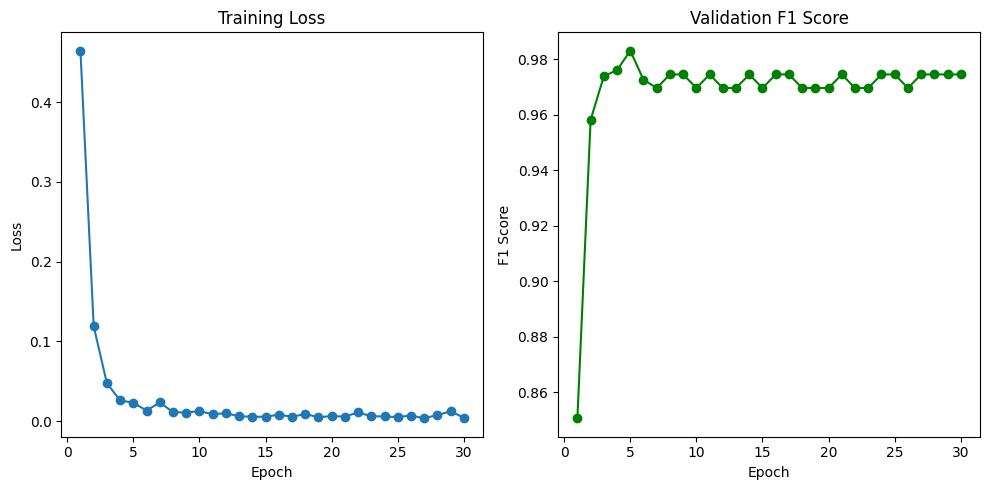

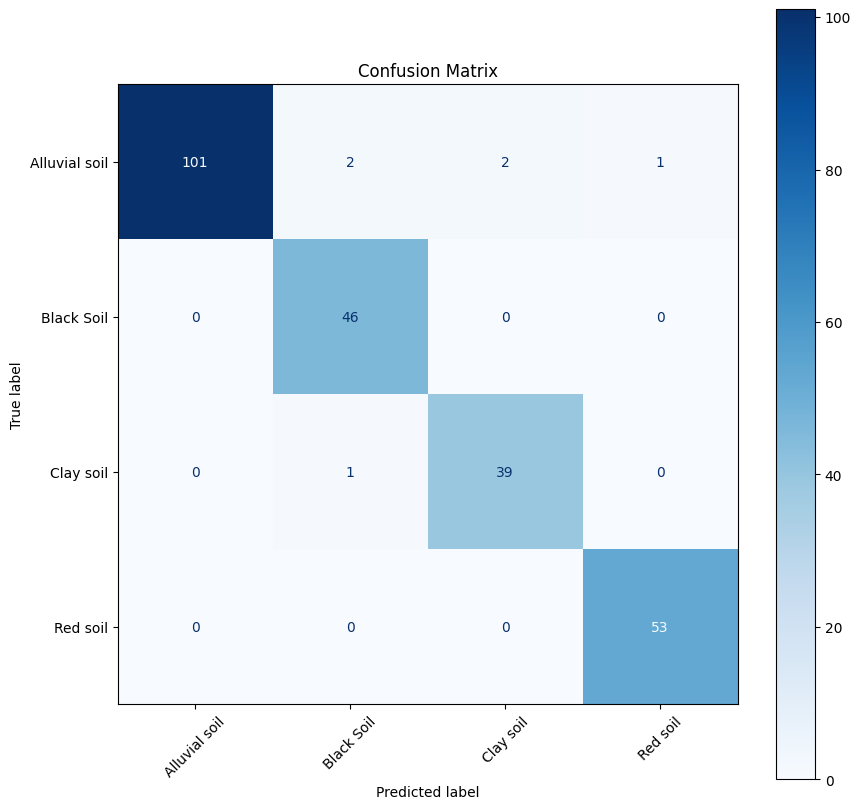

In [50]:
def plot_training_history(train_losses, val_f1_scores, save_path="training_history.png"):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, marker='o', color='green')
    plt.title("Validation F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

plot_training_history(train_losses, val_f1_scores, save_path="training_history.png")

def plot_confusion_matrix(true_labels, pred_labels, classes, save_path="confusion_matrix.png"):
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.savefig(save_path)  
    plt.show()

plot_confusion_matrix(val_true_labels, val_predictions, label_encoder.classes_, save_path="confusion_matrix.png")

In [52]:
class_names = label_encoder.classes_
f1_scores = f1_score(val_true_labels, val_predictions, average=None)

for name, score in zip(class_names, f1_scores):
    var_name = f"f1_{name.lower().replace(' ', '_')}"
    globals()[var_name] = score
    print(f"{var_name} = {score:.4f}")

f1_alluvial_soil = 0.9758
f1_black_soil = 0.9684
f1_clay_soil = 0.9630
f1_red_soil = 0.9907


# Save metrics to ml-metrics.json

In [53]:
metrics = {
    "_comment": "This JSON file contains the ML metrics for multiclass classification",
    "Name": "Sushmetha S R",
    "Kaggle Username": "sushmethasr21bai1162",
    "Team Name": "expendables",
    "f1 scores": {
        "_comment": "Here are the class wise f1 scores",
        "Alluvial soil": f1_alluvial_soil,
        "Red soil": f1_red_soil,
        "Black soil": f1_black_soil,
        "Clay soil": f1_clay_soil
    }
}
with open('ml-metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)
print("Saved metrics to ml-metrics.json")

Saved metrics to ml-metrics.json
